# Audio preprocessing
En este notebook se realizará el preprocesado de las muestras de audio. Se hará tanto para las muestras capturadas con
el microcontrolador como para las muestras de fuentes externas.

Las muestras ya están alineadas de origen y tienen una duración de 1 segundo.

# Imports

In [20]:
from librosa.core import load
from librosa import power_to_db, resample
from librosa.feature import melspectrogram
from matplotlib import cm
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_io as tfio

## Punto de partida
Mostramos ejemplos de las señales para todas las clases de audio, tanto externas como captadas con microcontrolador, sin
aplicar preprocesado.

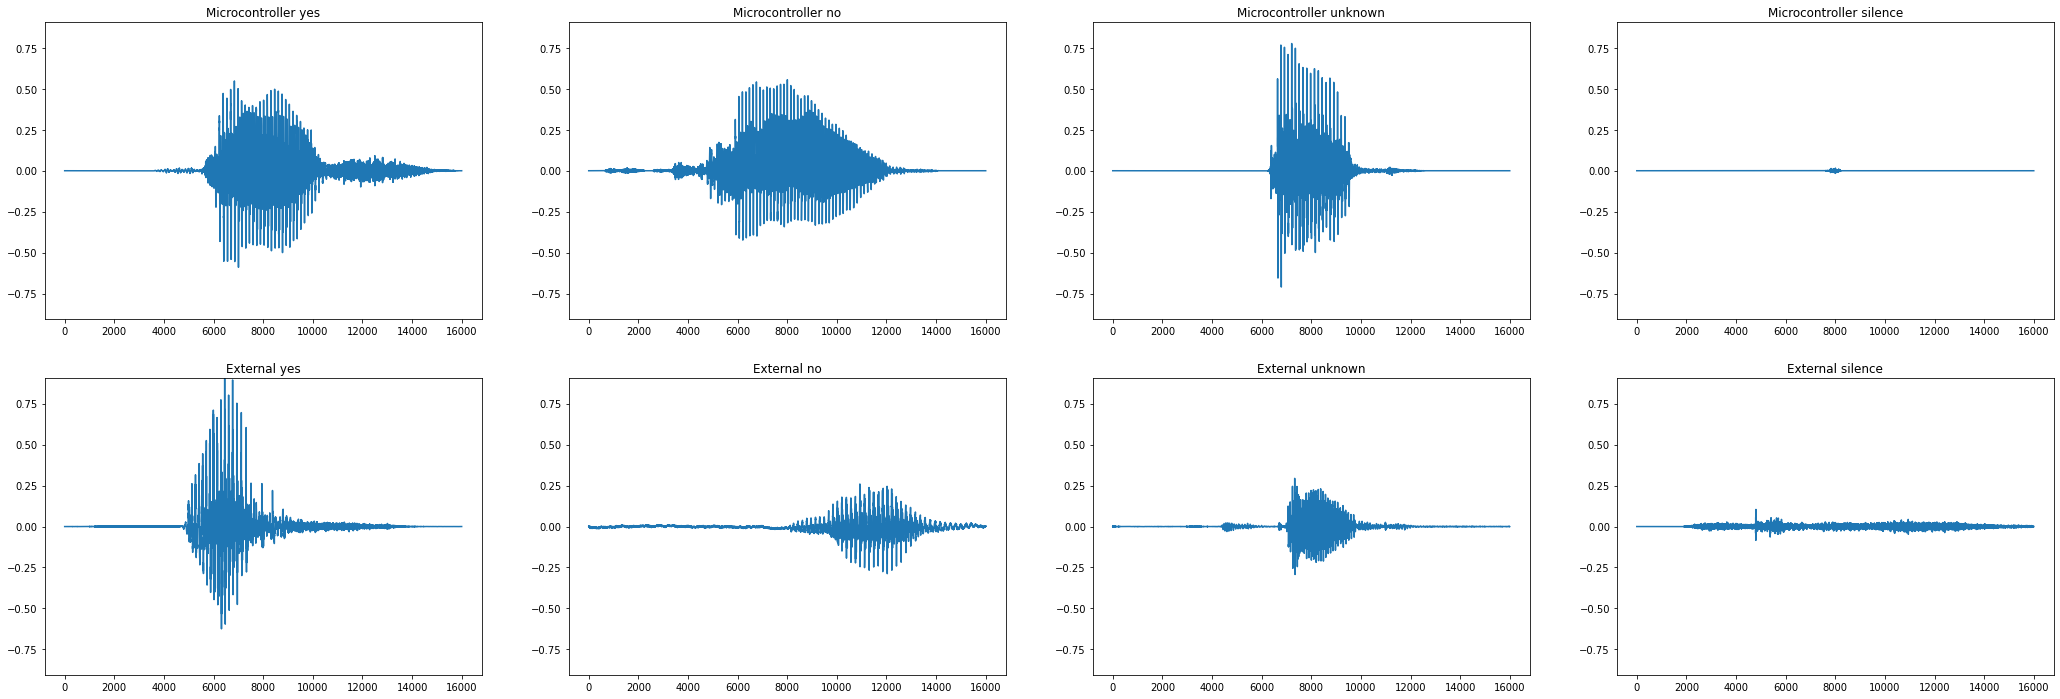

In [21]:
sr = 16000

micro_yes, sr_micro_yes = load("../samples/microcontroller/audio/yes/yes.22nm7k2s.s1.wav")
micro_yes = resample(micro_yes, sr_micro_yes, sr)
micro_no, sr_micro_no = load("../samples/microcontroller/audio/no/no.22nmmvgk.s1.wav")
micro_no = resample(micro_no, sr_micro_no, sr)
micro_unknown, sr_micro_unknown = load("../samples/microcontroller/audio/unknown/unknown.22nnierm.s1.wav")
micro_unknown = resample(micro_unknown, sr_micro_unknown, sr)
micro_silence, sr_micro_silence = load("../samples/microcontroller/audio/silence/silence.22nmsrh0.s1.wav")
micro_silence = resample(micro_silence, sr_micro_silence, sr)
ext_yes, sr_ext_yes = load("../samples/external/audio/yes/0a196374_nohash_1.wav")
ext_yes = resample(ext_yes, sr_ext_yes, sr)
ext_no, sr_ext_no = load("../samples/external/audio/no/34805883_nohash_0.wav")
ext_no = resample(ext_no, sr_ext_no, sr)
ext_unknown, sr_ext_unknown = load("../samples/external/audio/unknown/backward0a7c2a8d_nohash_0.wav")
ext_unknown = resample(ext_unknown, sr_ext_unknown, sr)
ext_silence, sr_ext_silence = load("../samples/external/audio/silence/silence.22nmtphe.s6.wav")
ext_silence = resample(ext_silence, sr_ext_silence, sr)

max_val = max(np.append(np.append(np.append(np.append(np.append(np.append(np.append(micro_yes, micro_no),
                                                                          micro_unknown), micro_silence),
                                                      ext_yes), ext_no), ext_unknown), ext_silence))
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(nrows=2, ncols=4)
ax1.plot(micro_yes)
ax1.set_title("Microcontroller yes")
ax1.set_ylim(-max_val, max_val)
ax2.plot(micro_no)
ax2.set_title("Microcontroller no")
ax2.set_ylim(-max_val, max_val)
ax3.plot(micro_unknown)
ax3.set_title("Microcontroller unknown")
ax3.set_ylim(-max_val, max_val)
ax4.plot(micro_silence)
ax4.set_title("Microcontroller silence")
ax4.set_ylim(-max_val, max_val)
ax5.plot(ext_yes)
ax5.set_title("External yes")
ax5.set_ylim(-max_val, max_val)
ax6.plot(ext_no)
ax6.set_title("External no")
ax6.set_ylim(-max_val, max_val)
ax7.plot(ext_unknown)
ax7.set_title("External unknown")
ax7.set_ylim(-max_val, max_val)
ax8.plot(ext_silence)
ax8.set_title("External silence")
ax8.set_ylim(-max_val, max_val)
fig.set_size_inches(36, 12)

## Fast Fourier Transform
La primera conversión que se aplica al sonido es Fast Fourier Transform. Esta transformación permite descomponer la
señal en una combinación de frecuencias, de manera que factores como el volumen dejan de afectar a los datos.

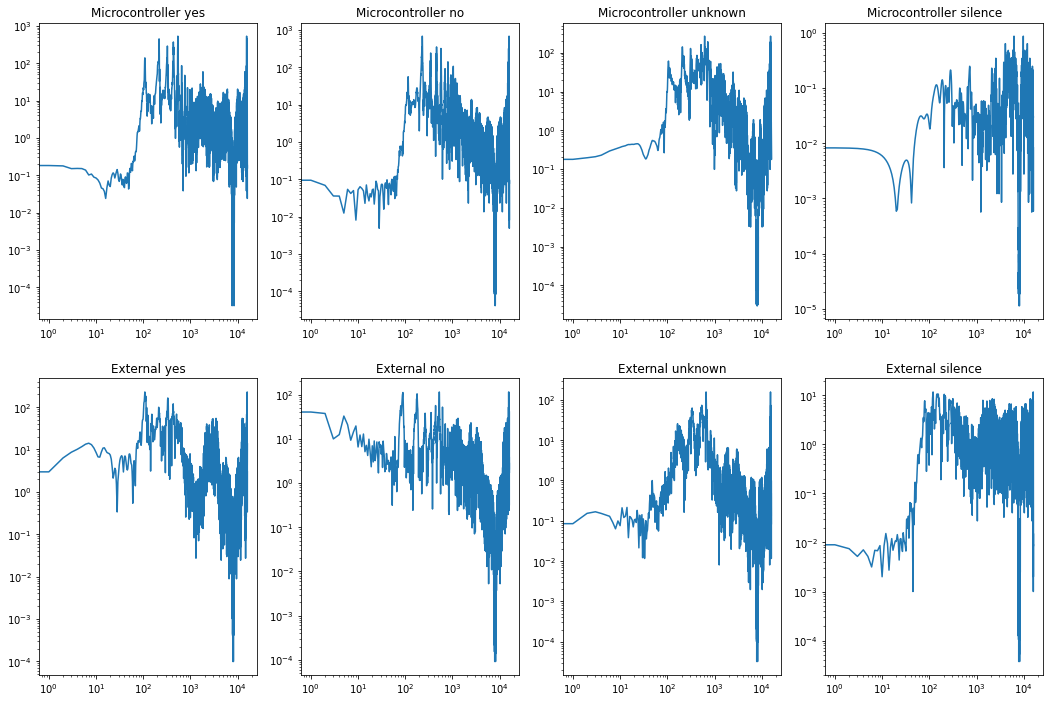

In [22]:
ft_micro_yes = np.abs(2*np.fft.fft(micro_yes))
ft_micro_no = np.abs(2*np.fft.fft(micro_no))
ft_micro_unknown = np.abs(2*np.fft.fft(micro_unknown))
ft_micro_silence = np.abs(2*np.fft.fft(micro_silence))
ft_ext_yes = np.abs(2*np.fft.fft(ext_yes))
ft_ext_no = np.abs(2*np.fft.fft(ext_no))
ft_ext_unknown = np.abs(2*np.fft.fft(ext_unknown))
ft_ext_silence = np.abs(2*np.fft.fft(ext_silence))

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(nrows=2, ncols=4)
ax1.plot(ft_micro_yes)
ax1.set_title("Microcontroller yes")
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.plot(ft_micro_no)
ax2.set_title("Microcontroller no")
ax2.set_xscale('log')
ax2.set_yscale('log')
ax3.plot(ft_micro_unknown)
ax3.set_title("Microcontroller unknown")
ax3.set_xscale('log')
ax3.set_yscale('log')
ax4.plot(ft_micro_silence)
ax4.set_title("Microcontroller silence")
ax4.set_xscale('log')
ax4.set_yscale('log')
ax5.plot(ft_ext_yes)
ax5.set_title("External yes")
ax5.set_xscale('log')
ax5.set_yscale('log')
ax6.plot(ft_ext_no)
ax6.set_title("External no")
ax6.set_xscale('log')
ax6.set_yscale('log')
ax7.plot(ft_ext_unknown)
ax7.set_title("External unknown")
ax7.set_xscale('log')
ax7.set_yscale('log')
ax8.plot(ft_ext_silence)
ax8.set_title("External silence")
ax8.set_xscale('log')
ax8.set_yscale('log')
fig.set_size_inches(18, 12)

## Espectrograma
Los espectrogramas son el resultado de calcular el espectro de una señal por ventanas de tiempo. Se pueden traducir en
una imagen bidimensional que puede ser interpretada por una red neuronal convolucional.

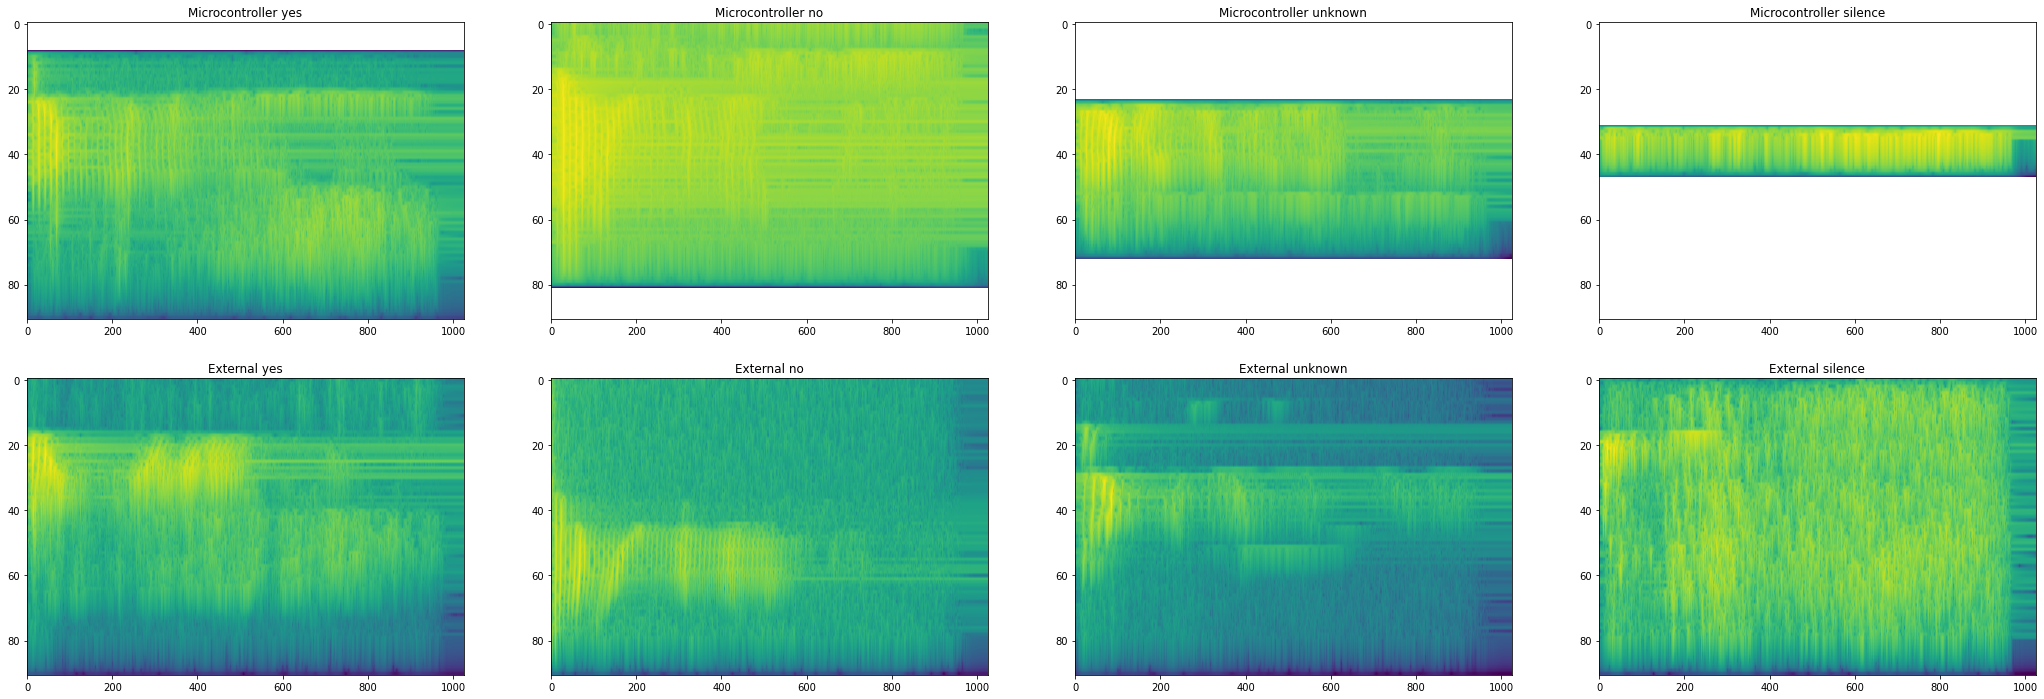

In [23]:
spec_micro_yes = tfio.experimental.audio.spectrogram(micro_yes/1.0, nfft=2048, window=len(micro_yes),
                                                     stride=int(sr_micro_yes * 0.008))
spec_micro_no = tfio.experimental.audio.spectrogram(micro_no/1.0, nfft=2048, window=len(micro_no),
                                                    stride=int(sr_micro_no * 0.008))
spec_micro_unknown = tfio.experimental.audio.spectrogram(micro_unknown/1.0, nfft=2048, window=len(micro_unknown),
                                                         stride=int(sr_micro_unknown * 0.008))
spec_micro_silence = tfio.experimental.audio.spectrogram(micro_silence/1.0, nfft=2048, window=len(micro_silence),
                                                         stride=int(sr_micro_silence * 0.008))
spec_ext_yes = tfio.experimental.audio.spectrogram(ext_yes/1.0, nfft=2048, window=len(ext_yes),
                                                   stride=int(sr_ext_yes * 0.008))
spec_ext_no = tfio.experimental.audio.spectrogram(ext_no/1.0, nfft=2048, window=len(ext_no),
                                                  stride=int(sr_ext_no * 0.008))
spec_ext_unknown = tfio.experimental.audio.spectrogram(ext_unknown/1.0, nfft=2048, window=len(ext_unknown),
                                                       stride=int(sr_ext_unknown * 0.008))
spec_ext_silence = tfio.experimental.audio.spectrogram(ext_silence/1.0, nfft=2048, window=len(ext_silence),
                                                       stride=int(sr_ext_silence * 0.008))

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(nrows=2, ncols=4)
ax1.imshow(tf.math.log(spec_micro_yes.numpy()), aspect='auto')
ax1.set_title("Microcontroller yes")
ax2.imshow(tf.math.log(spec_micro_no.numpy()), aspect='auto')
ax2.set_title("Microcontroller no")
ax3.imshow(tf.math.log(spec_micro_unknown.numpy()), aspect='auto')
ax3.set_title("Microcontroller unknown")
ax4.imshow(tf.math.log(spec_micro_silence.numpy()), aspect='auto')
ax4.set_title("Microcontroller silence")
ax5.imshow(tf.math.log(spec_ext_yes.numpy()), aspect='auto')
ax5.set_title("External yes")
ax6.imshow(tf.math.log(spec_ext_no.numpy()), aspect='auto')
ax6.set_title("External no")
ax7.imshow(tf.math.log(spec_ext_unknown.numpy()), aspect='auto')
ax7.set_title("External unknown")
ax8.imshow(tf.math.log(spec_ext_silence.numpy()), aspect='auto')
ax8.set_title("External silence")
fig.set_size_inches(36, 12)

## Mel-Filterbanks y MFCC
MFCC es un tipo de espectrograma que permite ajustar los datos para destacar el espectro audible por el ser humano. Es
de gran utilidad cuando los sonidos son de lenguaje humano.

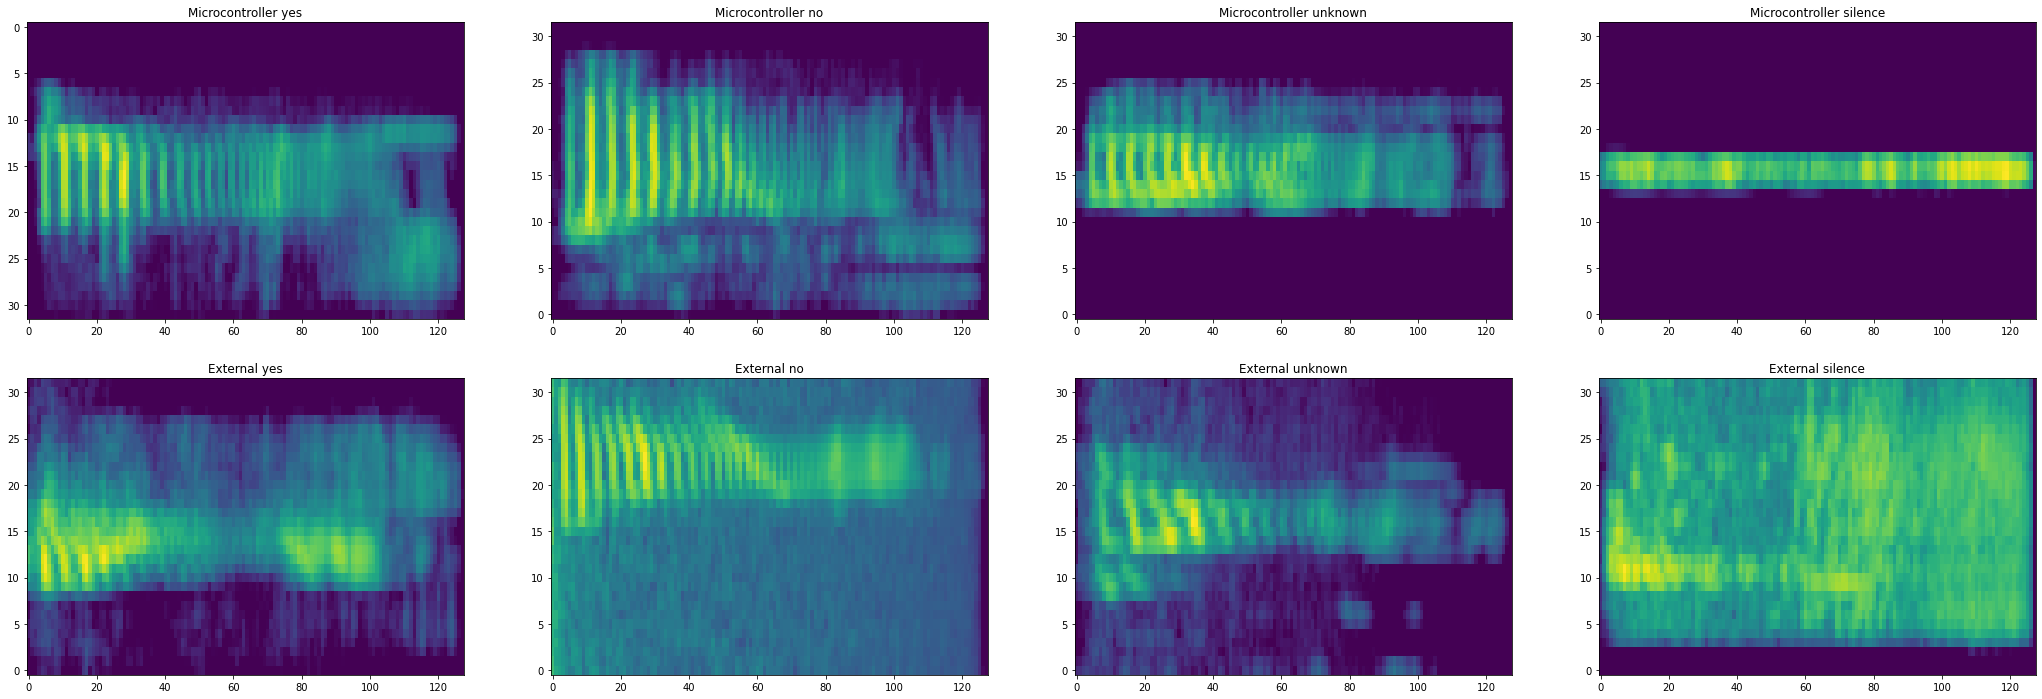

In [24]:
mfcc_micro_yes = power_to_db(melspectrogram(np.float32(micro_yes), sr=sr_micro_yes, n_fft=2048, hop_length=512,
                                            n_mels=128), ref=np.max)
mfcc_micro_no = power_to_db(melspectrogram(np.float32(micro_no), sr=sr_micro_no, n_fft=2048, hop_length=512,
                                           n_mels=128), ref=np.max)
mfcc_micro_unknown = power_to_db(melspectrogram(np.float32(micro_unknown), sr=sr_micro_unknown, n_fft=2048,
                                                hop_length=512, n_mels=128), ref=np.max)
mfcc_micro_silence = power_to_db(melspectrogram(np.float32(micro_silence), sr=sr_micro_silence, n_fft=2048,
                                                hop_length=512, n_mels=128), ref=np.max)
mfcc_ext_yes = power_to_db(melspectrogram(np.float32(ext_yes), sr=sr_ext_yes, n_fft=2048, hop_length=512, n_mels=128),
                           ref=np.max)
mfcc_ext_no = power_to_db(melspectrogram(np.float32(ext_no), sr=sr_ext_no, n_fft=2048, hop_length=512, n_mels=128),
                          ref=np.max)
mfcc_ext_unknown = power_to_db(melspectrogram(np.float32(ext_unknown), sr=sr_ext_unknown, n_fft=2048, hop_length=512,
                                              n_mels=128), ref=np.max)
mfcc_ext_silence = power_to_db(melspectrogram(np.float32(ext_silence), sr=sr_ext_silence, n_fft=2048, hop_length=512,
                                              n_mels=128), ref=np.max)

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(nrows=2, ncols=4)
ax1.imshow(np.swapaxes(mfcc_micro_yes, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax1.set_title("Microcontroller yes")
ax1.set_ylim(ax1.get_ylim()[::-1])
ax2.imshow(np.swapaxes(mfcc_micro_no, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax2.set_title("Microcontroller no")
ax2.set_ylim(ax1.get_ylim()[::-1])
ax3.imshow(np.swapaxes(mfcc_micro_unknown, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower',
           aspect='auto')
ax3.set_title("Microcontroller unknown")
ax3.set_ylim(ax1.get_ylim()[::-1])
ax4.imshow(np.swapaxes(mfcc_micro_silence, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower',
           aspect='auto')
ax4.set_title("Microcontroller silence")
ax4.set_ylim(ax1.get_ylim()[::-1])
ax5.imshow(np.swapaxes(mfcc_ext_yes, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax5.set_title("External yes")
ax5.set_ylim(ax1.get_ylim()[::-1])
ax6.imshow(np.swapaxes(mfcc_ext_no, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax6.set_title("External no")
ax6.set_ylim(ax1.get_ylim()[::-1])
ax7.imshow(np.swapaxes(mfcc_ext_unknown, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax7.set_title("External unknown")
ax7.set_ylim(ax1.get_ylim()[::-1])
ax8.imshow(np.swapaxes(mfcc_ext_silence, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax8.set_title("External silence")
ax8.set_ylim(ax1.get_ylim()[::-1])
fig.set_size_inches(36, 12)